#### Preparing metadata

In [1]:
import polars as pl
import os

def image_exists(path: str) -> bool:
    return os.path.exists(path)

df = pl.read_csv("images/metadata/images.csv")
df = df.filter(pl.col("height") >= 1000, pl.col("width") >= 1000)
df = df.filter(("images/small/" + df["path"]).map_elements(image_exists))

df.write_csv("images/metadata/filtered_images.csv")

#### Database setup

In [2]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db"
)

engine = create_engine(db_url)

In [3]:
from typing import List 
from pgvector.sqlalchemy import Vector
from sqlalchemy import Integer, String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column


class Base(DeclarativeBase):
    __abstract__ = True

class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH: int = 512
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(64), unique=True)
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))
    
Base.metadata.create_all(engine)

In [4]:
from sqlalchemy import inspect

inspector = inspect(engine)
print(inspector.get_table_names())

['images']


#### Model Selection

We'll be using multimodal CLIP ViT-B/32 model that produces 512-dim embeddings for both images and texts.
ViT in the model name stands for Vision Transformer which is used for initial preprocessing of images.
B stands for "Base", which describes model's size and 32 means that image is split into 32x32 pixel patches, when passed to Vision Transformer.

In [5]:
from sentence_transformers import SentenceTransformer
import torch

def choose_device() -> torch.device:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    return torch.device(device)

device = choose_device()
model_name = 'clip-ViT-B-32'

print(f"Running model: {model_name}, on device: {device}")
model = SentenceTransformer(model_name, device=device)

Running model: clip-ViT-B-32, on device: mps


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
import joblib
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session
from typing import Iterator

BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

def insert_images(engine, images: list[Img]):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()

def vectorize_images(
        engine, 
        model: SentenceTransformer, 
        image_paths: Iterator[pl.DataFrame],
        max_images: int
    ):

    with tqdm(total=max_images) as pbar:
        count = 0
        for images_paths_batch in image_paths:

            whole_paths = "images/small/" + images_paths_batch["path"]
            images = [
                Image.open(path) for path in whole_paths
            ]

            embeddings = model.encode(images)

            vectorized_images = [
                Img(image_path=path, embedding=embedding)
                for path, embedding in zip(whole_paths, embeddings)
            ]
                
            insert_images(engine, vectorized_images)
            if count >= max_images:
                break

            count += len(images)
            pbar.update(len(images))

Initially I'am adding 10_000 images.

In [7]:
lazy_batch_reader = (
    pl.scan_csv("images/metadata/filtered_images.csv")
    .select("path")
    .collect(engine="streaming")
    .iter_slices(n_rows=32)
)

vectorize_images(engine, model, lazy_batch_reader, max_images=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt
from sqlalchemy import select

class ImageSearch:
    def __init__(self, engine, model: SentenceTransformer):
        self.engine = engine
        self.model = model
        
    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        print(found_images)
        self.display_images(found_images)

    def find_similar_images(self, image_description: str, k: int) -> list[str]:
        description_embedding = self.model.encode(image_description)

        with Session(self.engine) as session:
            query = (
                select(Img.image_path)
                .order_by(Img.embedding.cosine_distance(description_embedding))
                .limit(k)
            )
            results = session.scalars(query).all()

        return results
    
    def extract_images(self, image_paths: list[str]) -> list[Image.Image]:
        images = [Image.open(path) for path in image_paths]
        return images
    
    def display_images(self, images: list[str]):
        k = len(images)
        fig, axes = plt.subplots(1, k, figsize=(15, 5))
        
        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        
        plt.show()

#### Testing the search engine

In [9]:
google_image = ImageSearch(engine, model)

['images/small/51/51471cbe.jpg', 'images/small/c1/c196ffa0.jpg', 'images/small/30/30883150.jpg', 'images/small/c8/c88efc4b.jpg', 'images/small/cb/cb43fe5f.jpg']


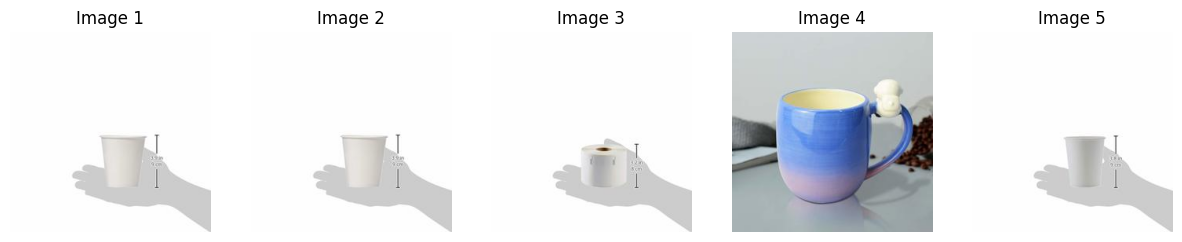

In [10]:
query = "a cup of tea"
google_image(query, 5)

['images/small/5b/5b73655a.jpg', 'images/small/0e/0e568cac.jpg', 'images/small/58/586aed53.jpg', 'images/small/47/471e8cdd.jpg', 'images/small/ee/eebdca1a.jpg']


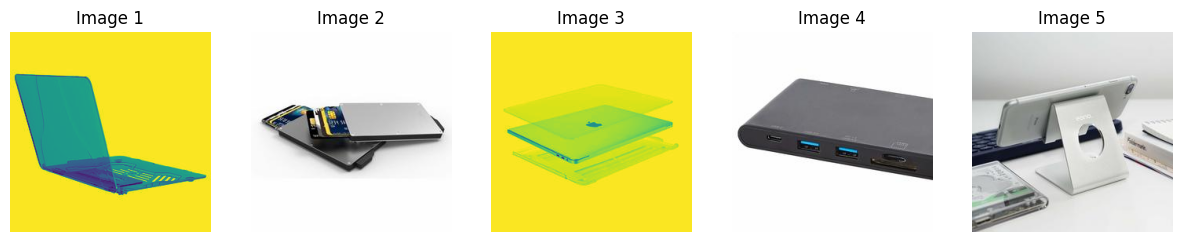

In [11]:
query = "Laptops and Computers"
google_image(query, 5)

['images/small/7c/7c498416.jpg', 'images/small/17/17191282.jpg', 'images/small/8d/8d05f551.jpg', 'images/small/e5/e51f4584.jpg', 'images/small/77/77a69974.jpg']


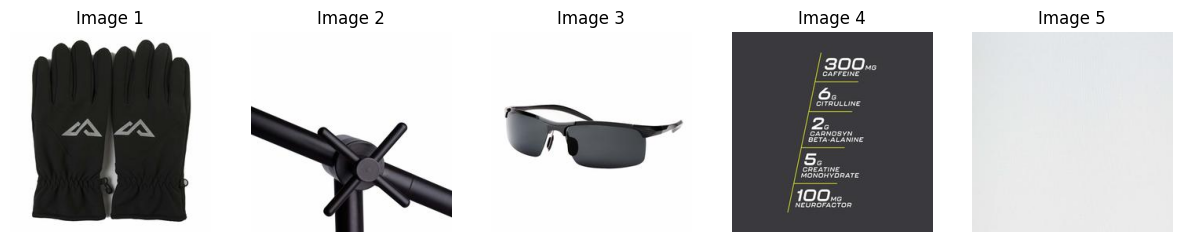

In [12]:
query = "Mountain bike ride"
google_image(query, 5)

Adding 50_000 images

In [13]:
vectorize_images(engine, model, lazy_batch_reader, max_images=50_000)

  0%|          | 0/50000 [00:00<?, ?it/s]

['images/small/51/51471cbe.jpg', 'images/small/c1/c196ffa0.jpg', 'images/small/0a/0abaec0a.jpg', 'images/small/b8/b8779b0b.jpg', 'images/small/30/30883150.jpg']


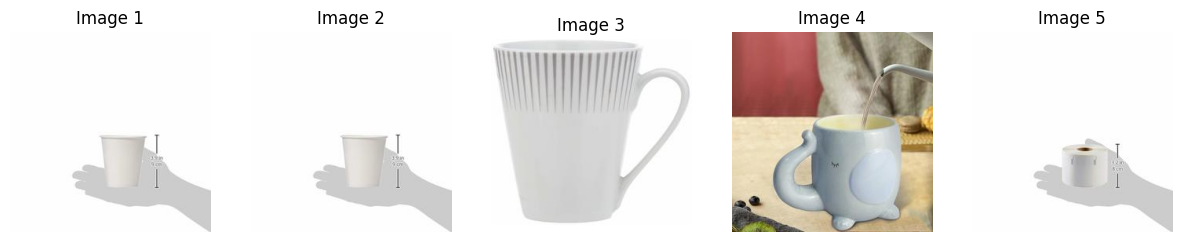

In [14]:
query = "a cup of tea"
google_image(query, 5)

['images/small/24/24065fcb.jpg', 'images/small/ff/fff26f4f.jpg', 'images/small/6b/6bce964a.jpg', 'images/small/70/70e1e00b.jpg', 'images/small/63/6397993e.jpg']


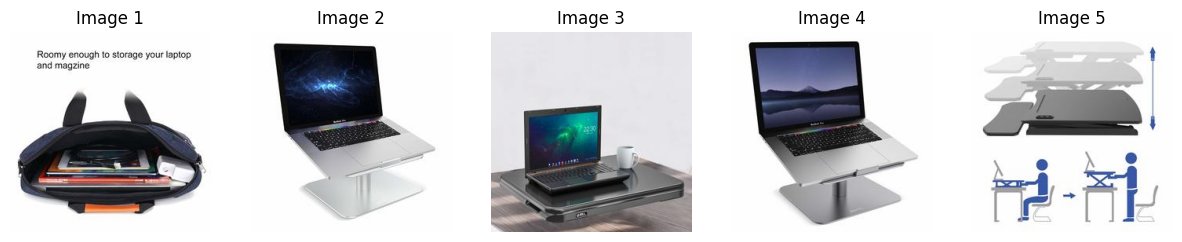

In [15]:
query = "Laptops and Computers"
google_image(query, 5)

['images/small/77/77f4ffe8.jpg', 'images/small/08/0850ff95.jpg', 'images/small/a4/a4833af4.jpg', 'images/small/d0/d077ff6b.jpg', 'images/small/7c/7c498416.jpg']


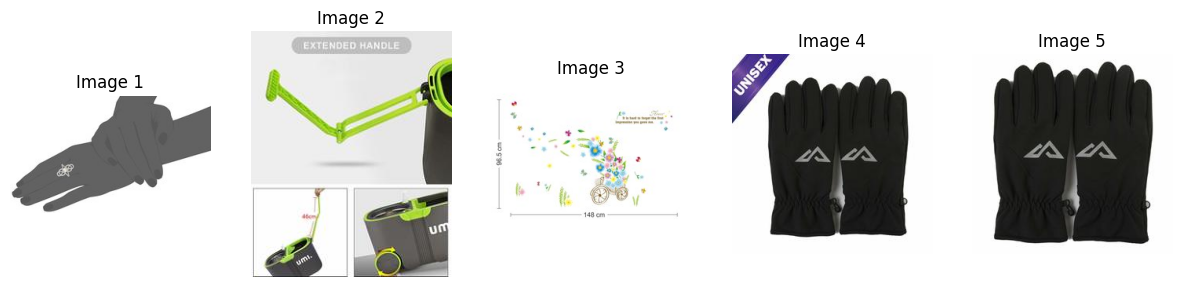

In [16]:
query = "Mountain bike ride"
google_image(query, 5)

Trying out with 200_000

In [17]:
vectorize_images(engine, model, lazy_batch_reader, max_images=200_000)

  0%|          | 0/200000 [00:00<?, ?it/s]

['images/small/51/51471cbe.jpg', 'images/small/c1/c196ffa0.jpg', 'images/small/2f/2fb77904.jpg', 'images/small/52/528c7ac7.jpg', 'images/small/0a/0abaec0a.jpg']


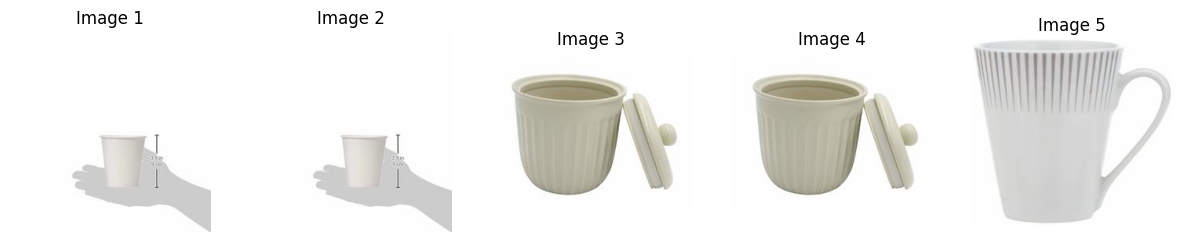

In [18]:
query = "a cup of tea"
google_image(query, 5)

['images/small/24/24065fcb.jpg', 'images/small/ae/aed7bdd8.jpg', 'images/small/a2/a2a8b895.jpg', 'images/small/ff/fff26f4f.jpg', 'images/small/6b/6bce964a.jpg']


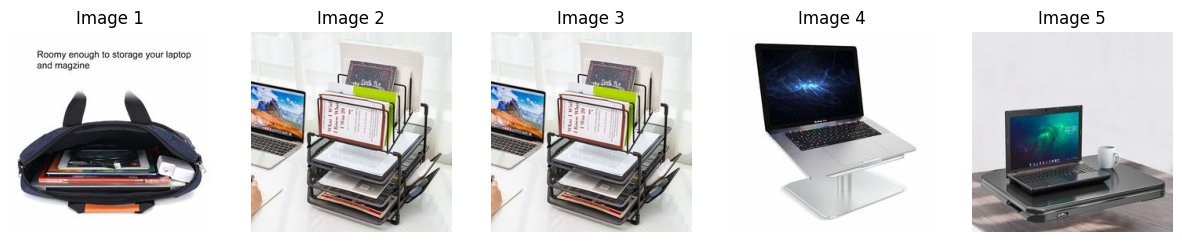

In [19]:
query = "Laptops and Computers"
google_image(query, 5)

['images/small/c6/c65ee619.jpg', 'images/small/0d/0d05d668.jpg', 'images/small/a9/a950628f.jpg', 'images/small/15/15880249.jpg', 'images/small/8d/8d93fed0.jpg']


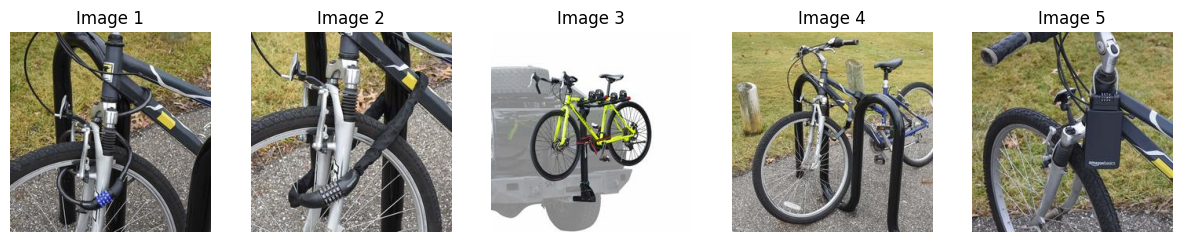

In [20]:
query = "Mountain bike ride"
google_image(query, 5)